In [1]:
!pip install beautifulsoup4
!pip install geopy

import re
import json
import requests
import numpy as np
from bs4 import BeautifulSoup

import pandas as pd
#display all rows
pd.set_option('display.max_rows', None)
#display all columns
pd.set_option('display.max_columns', None)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from geopy.geocoders import Nominatim

import folium

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

print('Libraries imported.')

     |████████████████████████████████| 122kB 19.3MB/s eta 0:00:01
Libraries imported.


In [11]:
data = pd.read_csv (r'blr_neighborhoods.csv')   
bang_data = pd.DataFrame(data, columns= ['Location','Latitude','Longitude'])
print (bang_data)

                         Location   Latitude   Longitude
0                           Agram  45.813177   15.977048
1                    Amruthahalli  13.066513   77.596624
2                           Attur  11.663711   78.533551
3                       Banaswadi  13.014162   77.651854
4                       Bellandur  58.235358   26.683116
5                   Bhattarahalli  13.025800   77.714279
6                      Bidrahalli  14.577426   74.928560
7                 Byatarayanapura  13.062074   77.596392
8                     Devanagundi  12.973613   77.839402
9                      Devasandra  12.757227   77.647280
10                     Doddagubbi  14.452076   75.510799
11                  Doddanekkundi  12.975720   77.694042
12                         Domlur  12.962467   77.638196
13                           EPIP  12.977673   77.722200
14                    Fraser Town  42.245363  -74.964607
15                         Gunjur  13.176020  -16.759896
16                      HighCou

In [15]:
bang_data.head()


,Location,Latitude,Longitude
0,Agram,45.813177,15.977048
1,Amruthahalli,13.066513,77.596624
2,Attur,11.663711,78.533551
3,Banaswadi,13.014162,77.651854
4,Bellandur,58.235358,26.683116


In [18]:
print(bang_data.shape)

(352, 3)


In [19]:
address = 'Bangalore, Karnataka'

geolocator = Nominatim(user_agent="bangalore_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Bangalore are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Bangalore are 12.9791198, 77.5912997.


In [23]:
bang_map = folium.Map(location=[latitude, longitude], zoom_start=12)    
bang_map

In [24]:
# add neighborhood markers to map
for lat, lng, location in zip(bang_data['Latitude'], bang_data['Longitude'], bang_data['Location']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(bang_map)  

bang_map

In [ ]:
CLIENT_ID = '1PTZ4GBORBZEXD10IHPQZF1N3RB11Y2MUKNN0EBKJ31F5W0Q' # your Foursquare ID
CLIENT_SECRET = 'A21B5CRBQMM5B0TZ0LNZT4IBTXSR1LZEMCYTCKTGVC2HBHVU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        count = 1
        while count != 5:
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
                count = 5
            except:
                count += 1
    
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
CLIENT_ID = '1PTZ4GBORBZEXD10IHPQZF1N3RB11Y2MUKNN0EBKJ31F5W0Q' # your Foursquare ID
CLIENT_SECRET = 'A21B5CRBQMM5B0TZ0LNZT4IBTXSR1LZEMCYTCKTGVC2HBHVU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

bang_venues = getNearbyVenues(names = bang_data['Location'],
                                 latitudes = bang_data['Latitude'],
                                 longitudes = bang_data['Longitude']
                                 )

print(bang_venues.shape)
bang_venues.head()

(776, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agram,45.813177,15.977048,Amélie,45.813842,15.979011,Dessert Shop
1,Agram,45.813177,15.977048,Trg bana Josipa Jelačića,45.813032,15.976868,Plaza
2,Agram,45.813177,15.977048,Vinodol,45.811666,15.975643,Mediterranean Restaurant
3,Agram,45.813177,15.977048,Tržnica Dolac,45.814070,15.977261,Farmers Market
4,Agram,45.813177,15.977048,Cremme Zagreb,45.814987,15.976296,Dessert Shop


In [29]:
bang_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Achitnagar,1,1,1,1,1,1
Adugodi,5,5,5,5,5,5
Agram,99,99,99,99,99,99
Akkur,28,28,28,28,28,28
Alahalli,1,1,1,1,1,1
Amruthahalli,3,3,3,3,3,3
Anekal,3,3,3,3,3,3
Arudi,3,3,3,3,3,3
Attibele,4,4,4,4,4,4


In [30]:
print('There are {} uniques categories.'.format(len(bang_venues['Venue Category'].unique())))

There are 179 uniques categories.


<AxesSubplot:xlabel='Neighborhood'>

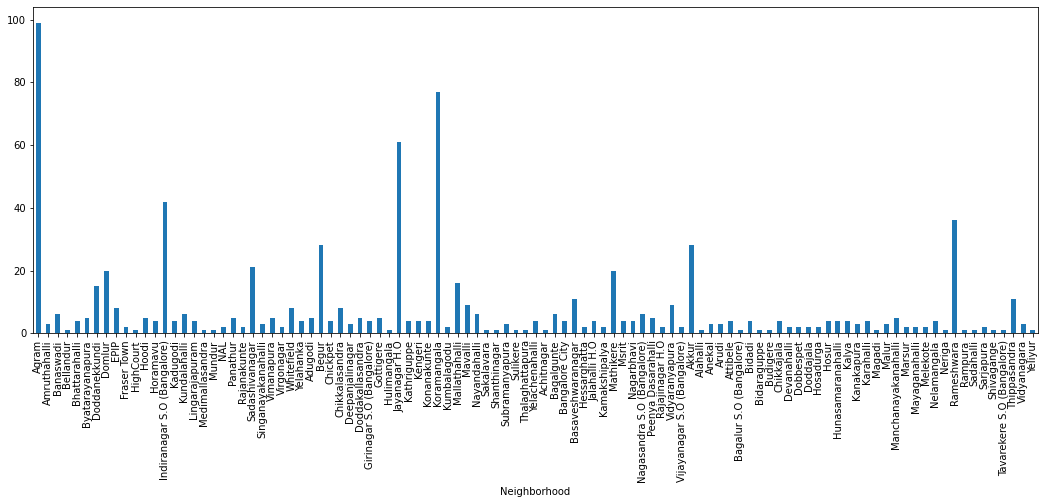

In [31]:
df = bang_venues.groupby(['Neighborhood'], sort=False)['Venue'].count()
df.plot.bar(figsize=(18,6))

<AxesSubplot:xlabel='Neighborhood'>

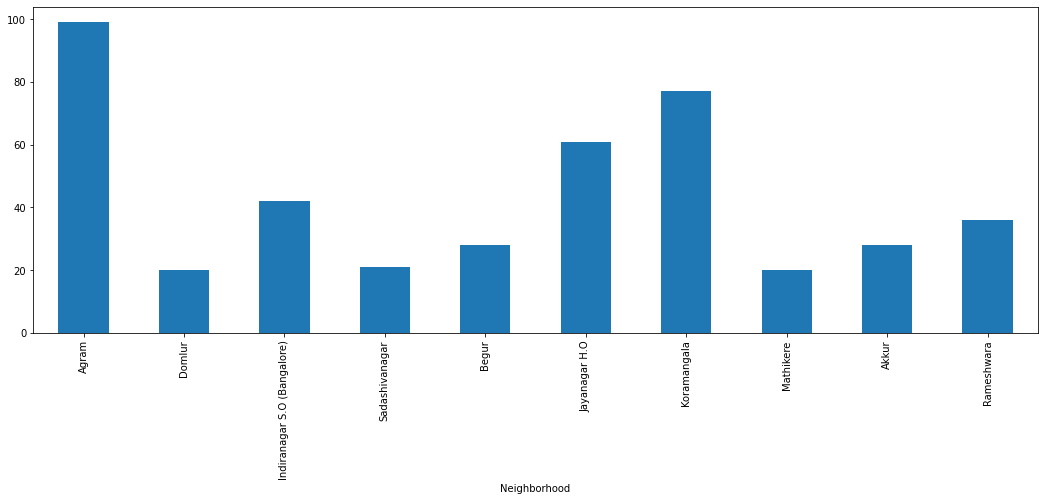

In [32]:
df = df[df >= 20]
df.plot.bar(figsize=(18,6))

In [33]:
bang_venues_top = bang_venues[bang_venues['Neighborhood'].isin(df.index.tolist())]
bang_venues_top.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agram,45.813177,15.977048,Amélie,45.813842,15.979011,Dessert Shop
1,Agram,45.813177,15.977048,Trg bana Josipa Jelačića,45.813032,15.976868,Plaza
2,Agram,45.813177,15.977048,Vinodol,45.811666,15.975643,Mediterranean Restaurant
3,Agram,45.813177,15.977048,Tržnica Dolac,45.814070,15.977261,Farmers Market
4,Agram,45.813177,15.977048,Cremme Zagreb,45.814987,15.976296,Dessert Shop


In [34]:
bang_onehot = pd.get_dummies(bang_venues_top['Venue Category'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bang_onehot['Neighborhood'] = bang_venues_top['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = bang_onehot.columns.tolist()
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Neighborhood')))
bang_onehot = bang_onehot.reindex(columns = fixed_columns)

print(bang_onehot.shape)
bang_onehot.head()

(432, 119)


,Neighborhood,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bar,Bengali Restaurant,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Station,Café,Candy Store,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Eastern European Restaurant,Electronics Store,Escape Room,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Food Court,Furniture / Home Store,Gastropub,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Historic Site,History Museum,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Italian Restaurant,Juice Bar,Karnataka Restaurant,Kerala Restaurant,Kids Store,Korean Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Multiplex,Museum,Music Venue,Optical Shop,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pizza Place,Plaza,Pub,Rajasthani Restaurant,Restaurant,Rock Club,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Shopping Plaza,Snack Place,South Indian Restaurant,Spa,Sports Bar,Steakhouse,Supermarket,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Toy / Game Store,Tunnel,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Agram,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Agram,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Agram,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Agram,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Agram,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
bang_grouped = bang_onehot.groupby('Neighborhood').mean().reset_index()
print(bang_grouped.shape)
bang_grouped.head()

(10, 119)


,Neighborhood,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bar,Bengali Restaurant,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Station,Café,Candy Store,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Eastern European Restaurant,Electronics Store,Escape Room,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Food Court,Furniture / Home Store,Gastropub,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Historic Site,History Museum,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Italian Restaurant,Juice Bar,Karnataka Restaurant,Kerala Restaurant,Kids Store,Korean Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Multiplex,Museum,Music Venue,Optical Shop,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pizza Place,Plaza,Pub,Rajasthani Restaurant,Restaurant,Rock Club,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Shopping Plaza,Snack Place,South Indian Restaurant,Spa,Sports Bar,Steakhouse,Supermarket,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Toy / Game Store,Tunnel,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Agram,0.0,0.0,0.0,0.010101,0.010101,0.010101,0.00,0.00000,0.090909,0.0,0.050505,0.0,0.00000,0.0,0.010101,0.0,0.020202,0.0,0.040404,0.0,0.000000,0.00000,0.000000,0.000000,0.010101,0.020202,0.000000,0.010101,0.000000,0.010101,0.00000,0.010101,0.040404,0.00000,0.000000,0.00000,0.030303,0.0,0.010101,0.010101,0.010101,0.00,0.0,0.000000,0.0,0.0,0.010101,0.00000,0.00000,0.010101,0.0,0.050505,0.010101,0.010101,0.020202,0.010101,0.010101,0.0,0.020202,0.010101,0.0,0.0,0.00000,0.000000,0.010101,0.010101,0.000000,0.0,0.060606,0.00000,0.00000,0.000000,0.0,0.0,0.010101,0.0,0.020202,0.00000,0.000000,0.0,0.020202,0.010101,0.030303,0.0,0.000000,0.000000,0.010101,0.010101,0.020202,0.070707,0.020202,0.00,0.020202,0.010101,0.000000,0.010101,0.010101,0.0,0.0,0.000000,0.0,0.0,0.00,0.010101,0.000000,0.00000,0.00000,0.0,0.030303,0.000000,0.010101,0.010101,0.00000,0.0,0.00000,0.020202,0.0,0.0
1,Akkur,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.00000,0.071429,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.071429,0.00000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.071429,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.071429,0.0,0.0,0.000000,0.00000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.071429,0.0,0.000000,0.000000,0.000000,0.0,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.071429,0.000000,0.000000,0.0,0.0,0.071429,0.0,0.0,0.00,0.000000,0.214286,0.00000,0.00000,0.0,0.000000,0.071429,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.0
2,Begur,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.00000,0.071429,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.071429,0.0,0.214286,0.0,0.000000,0.00000,0.071429,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.071429,0.000000,0.0,0.0,0.00000,0.071429,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.00000,0.071429,0.0,0.0,0.000000,0.0,0.000000,0

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create column names according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bang_grouped['Neighborhood']

for ind in np.arange(bang_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bang_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agram,Bar,Plaza,Mediterranean Restaurant,Historic Site,Bistro,Dessert Shop,Café,Theater,Eastern European Restaurant,Pedestrian Plaza
1,Akkur,Supermarket,Bar,Furniture / Home Store,Pet Store,Pharmacy,Snack Place,Optical Shop,Clothing Store,Toy / Game Store,Sandwich Place
2,Begur,Café,Supermarket,Italian Restaurant,Bar,Park,Pizza Place,Comedy Club,Climbing Gym,Burger Joint,Mini Golf
3,Domlur,Indian Restaurant,Café,Italian Restaurant,Liquor Store,Pizza Place,Pub,Rajasthani Restaurant,Restaurant,Chinese Restaurant,Sandwich Place
4,Indiranagar S.O (Bangalore),Lounge,Pub,Italian Restaurant,Indian Restaurant,Café,Restaurant,Cocktail Bar,Cupcake Shop,Mexican Restaurant,Men's Store


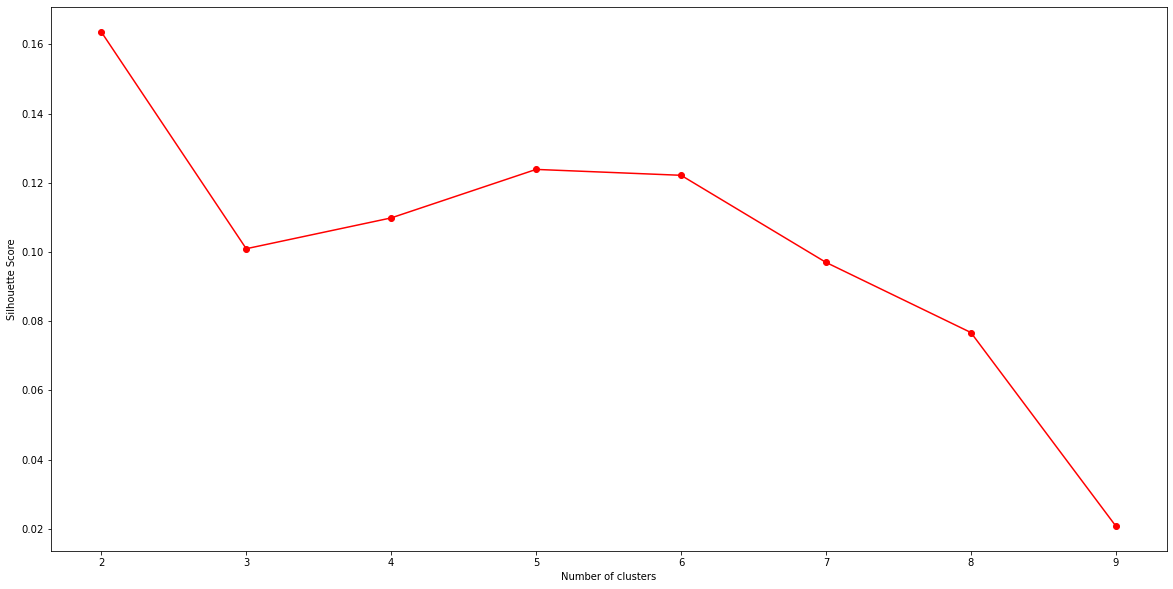

In [38]:
bang_grouped_clustering = bang_grouped.drop('Neighborhood', 1)

max_score = 10
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(bang_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(bang_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

In [39]:
# select best number of clusters
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bang_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [44]:
neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1, inplace=True)

In [45]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bang_merged = bang_venues_top[bang_venues_top.columns[0:3]].drop_duplicates()
bang_merged.reset_index(drop = True, inplace = True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bang_merged = bang_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

bang_merged.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agram,45.813177,15.977048,0,Bar,Plaza,Mediterranean Restaurant,Historic Site,Bistro,Dessert Shop,Café,Theater,Eastern European Restaurant,Pedestrian Plaza
1,Domlur,12.962467,77.638196,1,Indian Restaurant,Café,Italian Restaurant,Liquor Store,Pizza Place,Pub,Rajasthani Restaurant,Restaurant,Chinese Restaurant,Sandwich Place
2,Indiranagar S.O (Bangalore),12.973291,77.640467,1,Lounge,Pub,Italian Restaurant,Indian Restaurant,Café,Restaurant,Cocktail Bar,Cupcake Shop,Mexican Restaurant,Men's Store
3,Sadashivanagar,13.007708,77.579589,1,Indian Restaurant,Spa,Department Store,Coffee Shop,Dessert Shop,Ice Cream Shop,Plaza,Electronics Store,Chinese Restaurant,Seafood Restaurant
4,Begur,52.480709,13.451829,0,Café,Supermarket,Italian Restaurant,Bar,Park,Pizza Place,Comedy Club,Climbing Gym,Burger Joint,Mini Golf


In [46]:
bang_merged.loc[bang_merged['Cluster Labels'] == 0, bang_merged.columns[[0] + list(range(4, bang_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agram,Bar,Plaza,Mediterranean Restaurant,Historic Site,Bistro,Dessert Shop,Café,Theater,Eastern European Restaurant,Pedestrian Plaza
4,Begur,Café,Supermarket,Italian Restaurant,Bar,Park,Pizza Place,Comedy Club,Climbing Gym,Burger Joint,Mini Golf
8,Akkur,Supermarket,Bar,Furniture / Home Store,Pet Store,Pharmacy,Snack Place,Optical Shop,Clothing Store,Toy / Game Store,Sandwich Place


In [47]:
cluster1 = bang_merged.loc[bang_merged['Cluster Labels'] == 0, bang_merged.columns[[0] + 
                                                                                    list(range(4, bang_merged.shape[1]))]]
venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))

print(venues1.value_counts().head(10))

Bar                       3
Café                      2
Supermarket               2
Furniture / Home Store    1
Optical Shop              1
Pharmacy                  1
Toy / Game Store          1
Bistro                    1
Comedy Club               1
Climbing Gym              1
dtype: int64


In [48]:
bang_merged.loc[bang_merged['Cluster Labels'] == 1, bang_merged.columns[[0] + list(range(4, bang_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Domlur,Indian Restaurant,Café,Italian Restaurant,Liquor Store,Pizza Place,Pub,Rajasthani Restaurant,Restaurant,Chinese Restaurant,Sandwich Place
2,Indiranagar S.O (Bangalore),Lounge,Pub,Italian Restaurant,Indian Restaurant,Café,Restaurant,Cocktail Bar,Cupcake Shop,Mexican Restaurant,Men's Store
3,Sadashivanagar,Indian Restaurant,Spa,Department Store,Coffee Shop,Dessert Shop,Ice Cream Shop,Plaza,Electronics Store,Chinese Restaurant,Seafood Restaurant
5,Jayanagar H.O,Indian Restaurant,Café,Chinese Restaurant,Juice Bar,Sandwich Place,Fast Food Restaurant,Restaurant,Gastropub,Donut Shop,Candy Store
6,Koramangala,Indian Restaurant,Café,Coffee Shop,Pub,Italian Restaurant,Seafood Restaurant,Ice Cream Shop,Chinese Restaurant,Juice Bar,Kerala Restaurant
7,Mathikere,American Restaurant,Burger Joint,Ice Cream Shop,Market,Gym,Diner,Café,Bus Station,Indian Restaurant,Bakery
9,Rameshwara,Clothing Store,Indian Restaurant,Donut Shop,Fast Food Restaurant,Coffee Shop,Ice Cream Shop,Electronics Store,Rajasthani Restaurant,Pizza Place,Multiplex


In [49]:
cluster2 = bang_merged.loc[bang_merged['Cluster Labels'] == 1, bang_merged.columns[[0] + 
                                                                                    list(range(4, bang_merged.shape[1]))]]
venues2 = (cluster2['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']).append(
    cluster2['6th Most Common Venue']).append(
    cluster2['7th Most Common Venue']).append(
    cluster2['8th Most Common Venue']).append(
    cluster2['9th Most Common Venue']).append(
    cluster2['10th Most Common Venue']))

print(venues2.value_counts().head(10))

Indian Restaurant     7
Café                  5
Chinese Restaurant    4
Ice Cream Shop        4
Pub                   3
Coffee Shop           3
Restaurant            3
Italian Restaurant    3
Juice Bar             2
Seafood Restaurant    2
dtype: int64


IndexError: list index out of range

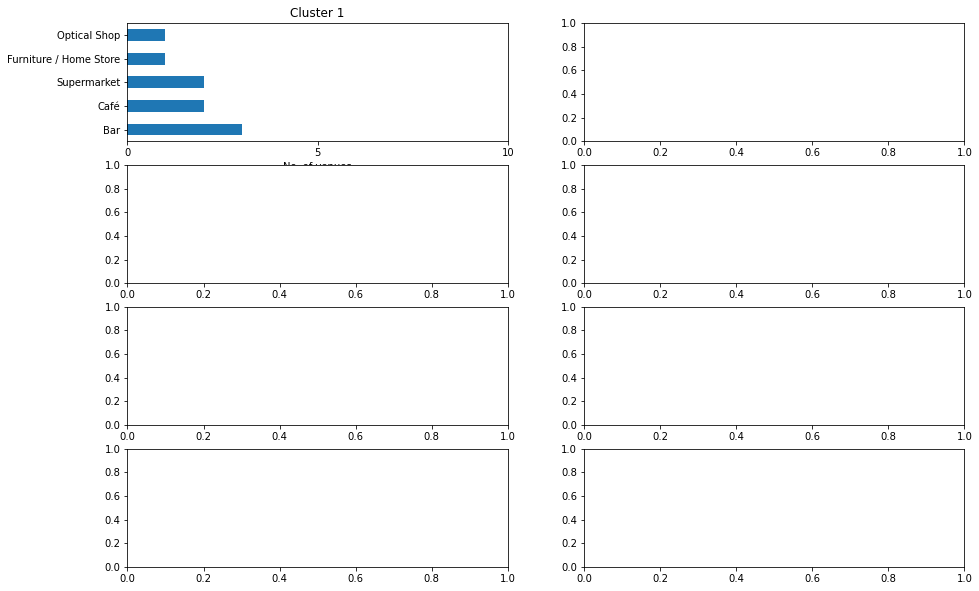

In [82]:
df_list = [venues1]
fig, axes = plt.subplots(4, 2)

count = 0
for r in range(4):
    for c in range(2):
        df_list[count].value_counts().head().plot.barh(ax = axes[r,c], width=0.5, figsize=(15,10))
        axes[r,c].set_title('Cluster {}'.format(count+1))
        plt.sca(axes[r, c])
        plt.xticks(np.arange(0, 15, 5))
        plt.xlabel('No. of venues')
        count += 1

fig.tight_layout()

In [83]:

# create map
bang_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bang_merged['Neighborhood Latitude'], bang_merged['Neighborhood Longitude'], bang_merged['Neighborhood'], bang_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(bang_clusters_map)
       
bang_clusters_map